In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors, tree, ensemble
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import statistics

In [2]:
#To hide FutureWarning & DataConversionWarning from the output
import warnings
from sklearn.exceptions import *
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Importing listings_v3

In [3]:
file = open('listings_v3', 'rb')
listings_v3 = pickle.load(file)
file.close()

listings_v3

,host_is_superhost,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,gym,elevator,wifi,breakfast,heating,air conditioning,tv,internet,extra pillows and blankets,polarity
0,0.0,Uskudar,41.05650,29.05367,Apartment,Entire home/apt,2,1.0,0.0,1.0,...,0,0,1,1,1,0,1,1,0,0.392083
1,0.0,Besiktas,41.06984,29.04545,Apartment,Entire home/apt,3,1.0,2.0,2.0,...,0,0,0,0,1,1,1,0,0,0.352256
2,0.0,Beyoglu,41.03220,28.98216,Apartment,Entire home/apt,2,1.0,1.0,1.0,...,0,0,1,0,1,0,1,1,1,0.472489
3,0.0,Sisli,41.04471,28.98567,Serviced apartment,Hotel room,5,1.0,1.0,3.0,...,0,1,1,0,1,1,1,1,0,NaN
4,0.0,Sariyer,41.09048,29.05559,Apartment,Entire home/apt,2,1.0,2.0,2.0,...,0,0,1,0,1,0,1,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20608,0.0,Beyoglu,41.03495,28.98621,Apartment,Entire home/apt,3,1.0,2.0,3.0,...,0,0,1,0,1,0,1,0,0,NaN
20609,0.0,Beyoglu,41.03027,28.97853,House,Private room,2,1.0,NaN,1.0,...,0,0,1,0,1,0,0,0,0,NaN
20610,0.0,Fatih,41.00408,28.97318,Boutique hotel,Private room,5,1.0,NaN,4.0,...,0,0,1,1,1,1,1,0,0,NaN
20611,0.0,Sariyer,41.10560,29.04835,Apartment,Private room,2,1.0,1.0,1.0,...,0,0,1,0,1,0,0,0,0,NaN


## Splitting the data into train and test

In [4]:
train_data, test_data = train_test_split(listings_v3, test_size=0.1, random_state=4)

train_x = train_data.drop("price", axis = 1).reset_index(drop=True)
train_y = train_data[["price"]].reset_index(drop=True)

test_x = test_data.drop("price", axis = 1).reset_index(drop=True)
test_y = test_data[["price"]].reset_index(drop=True)

# Data reprocessing for ML

## Handling Missing values

In [5]:
# finding features with Nan values
def nan_columns(dataframe):
    l = []
    for i in dataframe.columns:
        if dataframe[i].isnull().sum() != 0:
            l.append(i)
    return l

nan_features = nan_columns(train_x)
nan_features

['host_is_superhost',
 'bathrooms',
 'bedrooms',
 'beds',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'polarity']

In [6]:
# Dropping missing samples of irreparable features
def drop_nan(df1,df2,feature_list):
    for feature in feature_list:
        index = list(df1[df1[["{}".format(feature)]].isnull().any(axis = 1)].index)
        df1 = df1.drop(index, axis = 0).reset_index(drop = True)
        df2 = df2.drop(index, axis = 0).reset_index(drop = True)
    return df1, df2
    
train_x, train_y = drop_nan(train_x, train_y, ['review_scores_rating','review_scores_value',"review_scores_cleanliness","review_scores_accuracy"])
test_x, test_y = drop_nan(test_x,test_y, ['review_scores_rating','review_scores_value',"review_scores_cleanliness","review_scores_accuracy"])

In [7]:
#Filling other missing values with zero(the rest of them is numeric and discussed to be filled with "0")
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

## Pipeline for One hot encoding and standarization

In [8]:
# Finding categorical features :
def cat_columns(dataframe):
    categorical_columns = []
    for col in dataframe.columns:
        if (dataframe[["{}".format(col)]].dtypes == "object").bool() == True:
            categorical_columns.append(col)
    return categorical_columns

# Finding numerical features :
def num_columns(dataframe):
    categorical_columns = []
    for col in dataframe.columns:
        if (dataframe[["{}".format(col)]].dtypes == "float64").bool() == True or (dataframe[["{}".format(col)]].dtypes == "int64").bool() == True or (dataframe[["{}".format(col)]].dtypes == "int32").bool() == True:
            categorical_columns.append(col)
    return categorical_columns

# Convering the output data into a datafram:
class datafram_conv(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = pd.DataFrame(X)
        return X

# Imputer and scaler pipline for numerical features
num_transformer = Pipeline(steps = [("scaler", StandardScaler())])

# One-hot encoder for categorical features
cat_transformer = Pipeline(steps = [("encoder", OneHotEncoder(sparse = False, dtype = int, handle_unknown='error'))])

#Getting name of num and cat features
cat_features = cat_columns(train_x)
num_features = num_columns(train_x)

# Integrating num and cat transformer
processor = ColumnTransformer(transformers= [('num', num_transformer, num_features),
                                            ('cat', cat_transformer, cat_features)])

In [9]:
#Pipelines of data processing
final_pipe = Pipeline(steps = [('processor', processor),
                             ("datafram", datafram_conv())])

# Running data preprocessing pipeline
train_x_pipe = final_pipe.fit_transform(train_x)
test_x_pipe = final_pipe.transform(test_x)

In [10]:
#Dropping inf values
train_y[train_y==np.inf]=np.nan
test_y[test_y==np.inf]=np.nan

# taking the log of prices.
train_y = np.log(train_y)
test_y = np.log(test_y)

#checking the inf values
np.where(np.isinf(test_y)), np.where(np.isinf(train_y))

C:\Users\taylankabbani2019\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


((array([], dtype=int64), array([], dtype=int64)),
 (array([8291], dtype=int64), array([0], dtype=int64)))

In [11]:
#dropping them from both targets and features.
train_y = train_y.drop(train_y.index[8291])
train_x_pipe = train_x_pipe.drop(train_x_pipe.index[8291])   

# Model Training

### Linear Regression

In [12]:
# Creating the lr model
lr_model = LinearRegression()

#Training the model on train_x_e and train_y
lr_model.fit(train_x_pipe, train_y)

# Prediction of training set 
lr_train_predictions = lr_model.predict(train_x_pipe)

#Test data part
lr_test_predictions = lr_model.predict(test_x_pipe)

### Support Vector Regression

In [13]:
svr_reg = SVR("linear")

#fitting our data
svr_reg.fit(train_x_pipe, train_y)
#prediction on training
svr_train_predict = svr_reg.predict(train_x_pipe)

#test data part.
svr_test_predict = svr_reg.predict(test_x_pipe)

#rbf
svr_reg2 = SVR(kernel ='rbf')
svr_reg2.fit(train_x_pipe, train_y)
svr_train_predict_rbf = svr_reg2.predict(train_x_pipe)
svr_test_predict_rbf = svr_reg2.predict(test_x_pipe)



#poly
svr_reg3 = SVR(kernel = 'poly')
svr_reg3.fit(train_x_pipe, train_y)
svr_train_predict_poly = svr_reg3.predict(train_x_pipe)
svr_test_predict_poly = svr_reg3.predict(test_x_pipe)

### Ridge Regression

In [14]:
#created two dict. to first get all the scores and for second to get the mse.
all_scores = {}
mean_scores = {}

#in the loop, passed(i) as the alpha to get the values on lasso and after that get the cross_val_scores.
for i in range(1,20):
    ridge_reg = Ridge(alpha = i)
    ridge = ridge_reg.fit(train_x_pipe, train_y) 
    ridge_reg.predict(train_x_pipe)
    ridge_cross_scores = cross_val_score(ridge_reg, train_x_pipe, train_y, scoring="neg_mean_squared_error", cv=5)    
    all_scores[i] = abs(ridge_cross_scores)
    mean_scores[i] = abs(ridge_cross_scores.mean())

# the alpha from the min score from the mean scores dictionary.
min_alpha = min(mean_scores, key=mean_scores.get)
#pass the key to get the value of that.
min_error = mean_scores.get(min_alpha)

In [15]:
print(f"Minimum error was {round(min_error, 8)} at alpha {min_alpha}")

Minimum error was 0.266699 at alpha 1


In [16]:
ridge_reg = Ridge(alpha = i)
ridge_reg.fit(train_x_pipe, train_y) 

ridge_prediction_train = ridge_reg.predict(train_x_pipe)
ridge_prediction_test = ridge_reg.predict(test_x_pipe)

### Random Forest

In [17]:
# Random forest regression model:
forest_reg = ensemble.RandomForestRegressor()

# Hyperparameter possible combinations:
forest_hyperparameters = [{'n_estimators':[25, 50, 100, 250], 
                          'max_depth':[None, 1, 5, 10], 
                          'random_state':[0]}]
# Building Random forest model with grid search
forest_grid = GridSearchCV(forest_reg ,forest_hyperparameters, cv=5, scoring='neg_mean_squared_error')
forest_grid.fit(train_x_pipe, train_y)

# model's best parameters and MSE
print("model's best parameter: {}\nmodel's best MSE: {}".format(forest_grid.best_params_,
                                                                abs(forest_grid.best_score_)))

model's best parameter: {'max_depth': None, 'n_estimators': 250, 'random_state': 0}
model's best MSE: 0.22711352836482493


In [18]:
best_forest = RandomForestRegressor(max_depth = None, n_estimators = 250, random_state = 0)
best_forest.fit(train_x_pipe, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

### KNN

In [19]:
#creating split.
X_train, X_val, y_train, y_val = train_test_split(train_x_pipe, train_y, test_size=0.2, random_state = 0)
#renaming them as in the template.
train_split_x = X_train
train_split_y = y_train
val_split_x = X_val
val_split_y = y_val

#creating the error arrays
knn_training_errors = []
knn_validation_errors = []
#the for loop
for i in range(1,30):
    neighbor = KNeighborsRegressor(n_neighbors = i)
    neighbor.fit(train_split_x, train_split_y)
    train_neighbor_prediction = neighbor.predict(train_split_x)
    val_neighbor_prediction = neighbor.predict(val_split_x)
    #appending the arrays
    knn_training_errors.append(mean_squared_error(train_split_y, train_neighbor_prediction))
    knn_validation_errors.append(mean_squared_error(val_split_y, val_neighbor_prediction))

In [20]:
#getting the lowest error index for the best model.
validation_index_min = min(range(len(knn_validation_errors)), key=knn_validation_errors.__getitem__)
print("Min Error for validation is:", min(knn_validation_errors), ",index found at(index)", validation_index_min)

Min Error for validation is: 0.30311665059996734 ,index found at(index) 10


In [21]:
best_neighbor = KNeighborsRegressor(6)
best_neighbor.fit(train_split_x, train_split_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform')

Text(0, 0.5, 'Error')

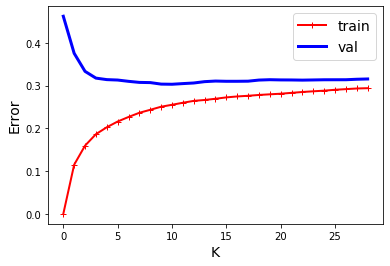

In [22]:
plt.plot((knn_training_errors), "r-+", linewidth=2, label="train")
plt.plot((knn_validation_errors), "b-", linewidth=3, label="val")
plt.legend(loc="upper right", fontsize=14)   
plt.xlabel("K", fontsize=14) 
plt.ylabel("Error", fontsize=14)

# Cross Validation Part

### Linear Regression

In [23]:
#Cross validation on the Linear Regression Mean Squared Scores
linear_model_cross_mse = cross_val_score(lr_model, train_x_pipe, train_y, scoring="neg_mean_squared_error", cv=10)
cross_linear_mse_scores = np.mean(abs(linear_model_cross_mse))

#Cross validation on the Linear Regression Abs Scores
linear_model_cross_absolute = cross_val_score(lr_model, train_x_pipe, train_y, scoring="neg_mean_absolute_error", cv=10)
cross_linear_abs_scores = np.mean(abs(linear_model_cross_absolute))

#Cross validation on the Linear regression R2 Scores
linear_model_cross_r2 = cross_val_score(lr_model, train_x_pipe, train_y, scoring="r2", cv=10)
cross_linear_r2_scores = np.mean(abs(linear_model_cross_r2))

### Support Vector Regression 

In [24]:
#Cross validation on the Support Vector Regression
best_svr_model_cross = cross_val_score(svr_reg2, train_x_pipe, train_y, scoring="neg_mean_squared_error", cv=10)
best_cross_svr_scores = abs((best_svr_model_cross))


best_svr_model_cross_abs = cross_val_score(svr_reg2, train_x_pipe, train_y, scoring="neg_mean_absolute_error", cv=10)
best_cross_svr_scores_abs = abs((best_svr_model_cross_abs))


best_svr_model_cross_r2 = cross_val_score(svr_reg2, train_x_pipe, train_y, scoring="r2", cv=10)
best_cross_svr_scores_r2 = abs((best_svr_model_cross_r2))

svr_round_mse = np.round(np.mean(best_cross_svr_scores),4)
svr_round_abs = np.round(np.mean(best_cross_svr_scores_abs),4)
svr_round_r2 = np.round(np.mean(best_cross_svr_scores_r2),4)

### Random Forest

In [25]:
#Cross validation on the Random Forest
best_randomforest_model_cross = cross_val_score(forest_reg, train_x_pipe, train_y, scoring="neg_mean_squared_error",cv=10)
best_cross_randomforest_scores = abs((best_randomforest_model_cross))



best_randomforest_model_cross_abs = cross_val_score(forest_reg, train_x_pipe, train_y, scoring="neg_mean_absolute_error", cv=10)
best_cross_randomforest_scores_abs = abs((best_randomforest_model_cross_abs))

best_randomforest_model_cross_r2 = cross_val_score(forest_reg, train_x_pipe, train_y, scoring="r2", cv=10)
best_cross_randomforest_scores_r2 = abs((best_randomforest_model_cross_r2))


rf_round_mse = np.round(np.mean(best_cross_randomforest_scores),4)
rf_round_abs = np.round(np.mean(best_cross_randomforest_scores_abs),4)
rf_round_r2 = np.round(np.mean(best_cross_randomforest_scores_r2),4)

### KNN

In [26]:
#Cross validation on the Random Forest
best_knn_model_cross = cross_val_score(best_neighbor, train_x_pipe, train_y, scoring="neg_mean_squared_error", cv=10)
best_cross_knn_scores = abs((best_knn_model_cross))

best_knn_model_cross_abs = cross_val_score(best_neighbor, train_x_pipe, train_y, scoring="neg_mean_absolute_error", cv=10)
best_cross_knn_scores_abs = abs((best_knn_model_cross_abs))

best_knn_model_cross_r2 = cross_val_score(best_neighbor, train_x_pipe, train_y, scoring="r2", cv=10)
best_cross_knn_scores_r2 = abs((best_knn_model_cross_r2))


knn_round_mse = np.round(np.mean(best_cross_knn_scores),4)
knn_round_abs = np.round(np.mean(best_cross_knn_scores_abs),4)
knn_round_r2 = np.round(np.mean(best_cross_knn_scores_r2),4)

### Ridge Regression

In [27]:
#Cross validation on the Ridge Regeression
ridge_model_cross = cross_val_score(ridge_reg, train_x_pipe, train_y, scoring="neg_mean_squared_error", cv=10)
ridge_mse_scores = abs((ridge_model_cross))

ridge_model_cross_abs = cross_val_score(ridge_reg, train_x_pipe, train_y, scoring="neg_mean_absolute_error", cv=10)
ridge_mse_scores_abs = abs((ridge_model_cross_abs))

ridge_model_cross_r2 = cross_val_score(ridge_reg, train_x_pipe, train_y, scoring="r2", cv=10)
ridge_mse_scores_r2 = abs((ridge_model_cross_r2))


ridge_round_mse = np.round(np.mean(ridge_mse_scores),4)
ridge_round_abs = np.round(np.mean(ridge_mse_scores_abs),4)
ridge_round_r2 = np.round(np.mean(ridge_mse_scores_r2),4)

## Getting scores of models

In [28]:
#Linear Regression Cross Validation
lin_cross = np.mean(cross_linear_mse_scores)

#Support Vector Cross Validation
svr_cross = np.mean(best_cross_svr_scores)

#Random Forest Cross Validation
random_forest_cross = np.mean(best_cross_randomforest_scores)

#KNN Cross Validation Score
knn_cross =  np.mean(best_cross_knn_scores)

#Ridge Regression Cross Validation Score
ridge_cross =  np.mean(ridge_mse_scores)

In [29]:
round_linear_abs = round(cross_linear_abs_scores,4 )
round_linear_mse = round(cross_linear_mse_scores,4 )
round_linear_r2 = round(cross_linear_r2_scores,4)

In [30]:
#KNN Scores
knn_train_predict = best_neighbor.predict(train_x_pipe)
knn_test_predict = best_neighbor.predict(test_x_pipe)

knn_train_mse = round(mean_squared_error(train_y, knn_train_predict),4)
knn_train_abs = round(mean_absolute_error(train_y, knn_train_predict),4)
knn_train_r2 = round(r2_score(train_y, knn_train_predict),4)

knn_test_mse = round(mean_squared_error(test_y, knn_test_predict),4)
knn_test_abs = round(mean_absolute_error(test_y, knn_test_predict ),4)
knn_test_r2 = round(r2_score(test_y, knn_test_predict),4)

In [31]:
#Random Forest Scores

forest_train_predict = best_forest.predict(train_x_pipe)
forest_test_predict = best_forest.predict(test_x_pipe)

forest_train_mse = round(mean_squared_error(train_y, forest_train_predict),4)
forest_train_abs = round(mean_absolute_error(train_y, forest_train_predict),4)
forest_train_r2 = round(r2_score(train_y, forest_train_predict),4)

forest_test_mse = round(mean_squared_error(test_y, forest_test_predict),4)
forest_test_abs = round(mean_absolute_error(test_y, forest_test_predict),4)
forest_test_r2 = round(r2_score(test_y, forest_test_predict),4)

In [32]:
#Ridge Scores
ridge_regression_train_mse = round(mean_squared_error(train_y, ridge_prediction_train),4)
ridge_regression_train_abs = round(mean_absolute_error(train_y, ridge_prediction_train),4)
ridge_regression_train_r2 = round(r2_score(train_y, ridge_prediction_train),4)

ridge_regression_test_mse = round(mean_squared_error(test_y, ridge_prediction_test),4)
ridge_regression_test_abs = round(mean_absolute_error(test_y, ridge_prediction_test),4)
ridge_regression_test_r2 = round(r2_score(test_y, ridge_prediction_test),4)

In [33]:
#SVR model mean absolute error, mean squared error, and r square scores for both training and test set.
svr_abs_training = round(mean_absolute_error(train_y,svr_train_predict),4)
svr_mse_training = round(mean_squared_error(train_y, svr_train_predict),4)
svr_r2_score = round(r2_score(train_y, svr_train_predict), 4)

svr_abs_test = round(mean_absolute_error(test_y,svr_test_predict),4)
svr_mse_test = round(mean_squared_error(test_y, svr_test_predict),4)
svr_r2_score_test = round(r2_score(test_y, svr_test_predict), 4)

In [34]:
#Linear model mean absolute error, mean squared error, and r square scores for both training and test set.
lr_abs_training = round(mean_absolute_error(train_y,lr_train_predictions),4)
lr_mse_training = round(mean_squared_error(train_y,lr_train_predictions),4)
lr_r2_score =  round(r2_score(train_y, lr_train_predictions), 4)


lr_abs_test= round(mean_absolute_error(test_y,lr_test_predictions),4)
lr_mse_test = round(mean_squared_error(test_y, lr_test_predictions),4)
lr_r2_score_test =  round(r2_score(test_y, lr_test_predictions), 4)

In [35]:
#SVR RBF AND POLY; mean absolute error, mean squared error, and r square scores for both training and test set.

# RBF
svr_mse_training_rbf = round(mean_squared_error(train_y, svr_train_predict_rbf),4)
svr_mae_training_rbf = round(mean_absolute_error(train_y, svr_train_predict_rbf),4)
svr_r2_score = round(r2_score(train_y, svr_train_predict_rbf),4)


svr_mse_test_rbf = round(mean_squared_error(test_y, svr_test_predict_rbf),4)
svr_mae_test_rbf = round(mean_absolute_error(test_y, svr_test_predict_rbf),4)
svr_r2_score_test = round(r2_score(test_y, svr_test_predict_rbf),4)

# POLY
svr_mse_training_poly = round(mean_squared_error(train_y, svr_train_predict_poly),4)
svr_mae_training_poly = round(mean_absolute_error(train_y, svr_train_predict_poly),4)
svr_r2_score_poly = round(r2_score(train_y, svr_train_predict_poly),4)


svr_mse_test_poly = round(mean_squared_error(test_y, svr_test_predict_poly),4)
svr_mae_test_poly = round(mean_absolute_error(test_y, svr_test_predict_poly),4)
svr_r2_score_test_poly = round(r2_score(test_y, svr_test_predict_poly),4)

In [36]:
print("Model Name","       " ,"         Training split", "      ", "                                Test split")
print("          ","      MAE   ",  "     MSE   ", "        R^2","   ", "                        MAE   ",  "  MSE    ", "R^2")
 
print("Linear       ",round_linear_abs, round_linear_mse, round_linear_r2,"  ",lr_abs_test,"",lr_mse_test," ",lr_r2_score_test)
print("SVR(RBF)     ",svr_round_abs,"      ", svr_round_mse,"        ", svr_round_r2,"                         ",svr_mae_test_rbf," ",svr_mse_test_rbf," ",svr_r2_score_test)
print("Ridge Regr.  ",ridge_round_abs,"       ",ridge_round_mse,"        ",ridge_round_r2,"                         ",ridge_regression_test_abs," ",ridge_regression_test_mse," ",ridge_regression_test_r2)
print("Random Forest",rf_round_abs,"      ",rf_round_mse,"        ",rf_round_r2,"                         ",forest_test_abs ,"   ",forest_test_mse," ",forest_test_r2 )
print("KNN          ",knn_round_abs,"      ",knn_round_mse,"        ",knn_round_r2,"                         ", knn_test_abs," ",knn_test_mse," ", knn_test_r2)

Model Name                  Training split                                        Test split
                 MAE         MSE            R^2                             MAE      MSE     R^2
Linear        216705319.5045 7.3502319111504806e+19 1.2641363308986927e+20    0.3872  0.2583   0.5424
SVR(RBF)      0.3429        0.2358          0.5968                           0.3529   0.2228   0.6053
Ridge Regr.   0.3776         0.268          0.5408                           0.3858   0.2564   0.5457
Random Forest 0.3567        0.2477          0.5712                           0.3416     0.2147   0.6197
KNN           0.4043        0.3044          0.477                           0.4258   0.3145   0.4428


In [37]:
random_forest_best_model = r2_score(test_y,forest_test_predict)
print(random_forest_best_model)

0.6196824194937167
